In [1]:
from datetime import datetime
import json
from collections import Counter

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
import torchmetrics

from deeprec.torch.trainer import Trainer, set_device
from deeprec import ROOT

In [2]:
with open('../data/metadata.json', 'r') as fp:
    meta = json.load(fp)

meta.keys()

dict_keys(['title_emb_size', 'string_na', 'genres', 'ages', 'occupations', 'user', 'movie', 'city', 'state'])

In [3]:
class Vocab(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, x):
        c = Counter(x)
        self.lookup_ = {
            str(v).lower(): k for k, v in enumerate([x[0] for x in sorted(c.items(), key=lambda x: x[1], reverse=True)])
        }

    def transform(self, x):
        return [self.lookup_.get(str(xx).lower(), len(self.lookup_)+1) for xx in x]

In [4]:
df = pd.read_parquet('../data/train.parq.gzip').drop('rating', axis=1)
df.head()

,user,movie,hour,day_of_week,month,ts,gender,age,occupation,city,...,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24
index,,,,,,,,,,,,,,,,,,,,,
693094,1489,2648,3,5,11,2000-11-25 03:35:14,1,35,2,Evanston,...,0.059832,0.46583,0.774960,0.43321,0.370830,0.140020,0.521110,-0.960430,-0.622770,0.245130
563664,2440,3101,17,1,11,2000-11-14 17:03:49,0,50,17,Ashburnham,...,1.982520,0.84989,1.708770,1.34452,-1.051670,-0.032240,0.662540,-0.448420,-1.197040,-0.698660
192,682,1193,16,3,11,2000-11-30 16:33:10,0,25,4,Carrboro,...,2.176160,2.86298,2.238394,-2.15952,1.210480,-3.436165,-0.329595,3.619880,-2.470530,1.399963
664671,3512,1005,17,0,8,2000-08-28 17:16:19,0,18,17,Cambridge,...,-1.662040,0.99335,-1.184181,1.58626,0.718946,-1.731300,2.357530,1.096584,-2.896070,0.150750
967203,5074,1202,5,5,7,2000-07-01 05:14:36,0,1,0,Purcellville,...,1.998510,1.07155,-0.863230,0.24211,-0.773756,0.235041,1.170840,-2.078201,-1.310696,-0.964250


In [5]:
state_enc = Vocab()
state_enc.fit(df['state'])

user_enc = Vocab()
user_enc.fit(df['user'])

movie_enc = Vocab()
movie_enc.fit(df['movie'])

In [6]:
df = pd.read_parquet('../data/train.parq.gzip', columns=['rating'])
df.head()

,rating
index,
693094,3
563664,4
192,5
664671,3
967203,5


In [7]:
set(df['rating'])

{1, 2, 3, 4, 5}

In [8]:
class MovieDataset(Dataset):
    def __init__(self, filename, vocabs):
        drop_cols = ['rating', 'city', 'hour', 'day_of_week', 'month', 'ts']
        x = pd.read_parquet(filename).drop(drop_cols, axis=1)
        y = pd.read_parquet(filename, columns=['rating'])

        x['state'] = vocabs['state'].transform(x['state'])
        x['user'] = vocabs['user'].transform(x['user'])
        x['movie'] = vocabs['movie'].transform(x['movie'])

        self.feature_names = x.columns
        self.x = x.to_dict('records')
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [9]:
encoders = {
    'user': user_enc,
    'movie': movie_enc,
    'state': state_enc
}

train = MovieDataset('../data/train.parq.gzip', vocabs=encoders)
test = MovieDataset('../data/test.parq.gzip', vocabs=encoders)

In [10]:
print(len(train.feature_names))
train.feature_names

50


Index(['user', 'movie', 'gender', 'age', 'occupation', 'state', 'year',
       'genre_action', 'genre_adventure', 'genre_animation', 'genre_childrens',
       'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
       'genre_fantasy', 'genre_filmnoir', 'genre_horror', 'genre_musical',
       'genre_mystery', 'genre_romance', 'genre_scifi', 'genre_thriller',
       'genre_war', 'genre_western', 'embed_0', 'embed_1', 'embed_2',
       'embed_3', 'embed_4', 'embed_5', 'embed_6', 'embed_7', 'embed_8',
       'embed_9', 'embed_10', 'embed_11', 'embed_12', 'embed_13', 'embed_14',
       'embed_15', 'embed_16', 'embed_17', 'embed_18', 'embed_19', 'embed_20',
       'embed_21', 'embed_22', 'embed_23', 'embed_24'],
      dtype='object')

In [11]:
dl = DataLoader(train, 4)
next(iter(dl))

[{'user': tensor([ 406, 5675, 3393,  579]),
  'movie': tensor([ 779,  309,   42, 1741]),
  'gender': tensor([1, 0, 0, 0]),
  'age': tensor([35, 50, 25, 18]),
  'occupation': tensor([ 2, 17,  4, 17]),
  'state': tensor([ 3,  5, 18,  5]),
  'year': tensor([1931, 1987, 1975, 1996]),
  'genre_action': tensor([0, 0, 0, 0]),
  'genre_adventure': tensor([0, 0, 0, 0]),
  'genre_animation': tensor([0, 0, 0, 0]),
  'genre_childrens': tensor([0, 0, 0, 1]),
  'genre_comedy': tensor([0, 0, 0, 1]),
  'genre_crime': tensor([0, 0, 0, 0]),
  'genre_documentary': tensor([0, 0, 0, 0]),
  'genre_drama': tensor([0, 0, 1, 0]),
  'genre_fantasy': tensor([0, 0, 0, 0]),
  'genre_filmnoir': tensor([0, 0, 0, 0]),
  'genre_horror': tensor([1, 0, 0, 0]),
  'genre_musical': tensor([0, 0, 0, 0]),
  'genre_mystery': tensor([0, 0, 0, 0]),
  'genre_romance': tensor([0, 0, 0, 0]),
  'genre_scifi': tensor([0, 0, 0, 0]),
  'genre_thriller': tensor([0, 1, 0, 0]),
  'genre_war': tensor([0, 0, 0, 0]),
  'genre_western': tens

In [12]:
z = next(iter(dl))

In [13]:
def stack_features(inputs, feat):
    return torch.stack([v for k, v in inputs.items() if feat in k], 1)


stack_features(z[0], 'genre')

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [34]:
class RecModel(nn.Module):
    def __init__(self, metadata, n_features=54):
        super().__init__()
        self.meta = metadata
        self.embed_dims = {
            'large': 32,
            'med': 16,
            'small': 8,
        }
        self.loss_func = nn.MSELoss()

        self.user_embeds = nn.Embedding(
            num_embeddings=len(user_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['large']
        )

        self.movie_embeds = nn.Embedding(
            num_embeddings=len(movie_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['large']
        )

        self.model = nn.Sequential(
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        user_block = self.user_embeds(x['user'])
        movie_block = self.movie_embeds(x['movie'])
        x = self.model(torch.concat((user_block, movie_block), dim=1))
        return x

    def predict(self, x):
        return self(x)

In [39]:
NOW = datetime.now().strftime('%Y%m%d-%H%M')
MODEL_NAME = 'simple-collab-filter'
LOG_DIR = ROOT.joinpath('runs', MODEL_NAME, NOW)
BATCH = 2500
EPOCHS = 15

train_loader = DataLoader(train, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH)

device = set_device()
mod = RecModel(metadata=meta)
opt = torch.optim.AdamW(mod.parameters(), lr=1e-2)
sch = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=.5)

trainer = Trainer(
    mod, epochs=EPOCHS, device=device, log_dir=LOG_DIR, checkpoint_file=LOG_DIR.joinpath('model.pt'),
    optimizer=opt, score_funcs={'mse': torchmetrics.MeanSquaredError()}, lr_schedule=sch
)
trainer.fit(train_loader, test_loader, verbose=True)

Batch: 100%|█████████▉| 360/361 [00:24<00:00, 19.82it/s]
                                                        
Epoch:   7%|▋         | 1/15 [00:26<06:11, 26.51s/it] 

defaultdict(<class 'list'>, {'epoch': [0], 'train_loss': [1.147230225751935], 'train_mse': [1.0958671569824219], 'valid_loss': [0.8710660556467568], 'valid_mse': [0.8634558320045471]})



Batch: 100%|██████████| 361/361 [00:21<00:00, 14.23it/s]
                                                        
Epoch:  13%|█▎        | 2/15 [00:50<05:23, 24.92s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1], 'train_loss': [1.147230225751935, 0.8411845754718517], 'train_mse': [1.0958671569824219, 0.8256677985191345], 'valid_loss': [0.8710660556467568, 0.8579303346029142], 'valid_mse': [0.8634558320045471, 0.8535840511322021]})



Batch: 100%|█████████▉| 360/361 [00:22<00:00, 16.51it/s]
                                                        
Epoch:  20%|██        | 3/15 [01:13<04:51, 24.30s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966], 'valid_mse': [0.8634558320045471, 0.8535840511322021, 0.8577994108200073]})



Batch:  99%|█████████▉| 359/361 [00:21<00:00, 21.12it/s]
                                                        
Epoch:  27%|██▋       | 4/15 [01:36<04:20, 23.69s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752], 'valid_mse': [0.8634558320045471, 0.8535840511322021, 0.8577994108200073, 0.8401986956596375]})



Batch:  99%|█████████▉| 359/361 [00:21<00:00, 21.33it/s]
                                                        
Epoch:  33%|███▎      | 5/15 [01:59<03:54, 23.48s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524, 0.7955763060960743], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927, 0.7808030247688293], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752, 0.8471447578290614], 'valid_mse': [0.8634558320045471, 0.8535840511322021, 0.8577994108200073, 0.8401986956596375, 0.8422298431396484]})



Batch: 100%|█████████▉| 360/361 [00:22<00:00, 16.25it/s]
                                                        
Epoch:  40%|████      | 6/15 [02:23<03:32, 23.58s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524, 0.7955763060960743, 0.7663873265654757], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927, 0.7808030247688293, 0.7586297988891602], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752, 0.8471447578290614, 0.8402325074847151], 'valid_mse': [0.8634558320045471, 0.8535840511322021, 0.8577994108200073, 0.8401986956596375, 0.8422298431396484, 0.8305519223213196]})



Batch: 100%|██████████| 361/361 [00:23<00:00, 20.58it/s]
                                                        
Epoch:  47%|████▋     | 7/15 [02:47<03:10, 23.86s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524, 0.7955763060960743, 0.7663873265654757, 0.7575149810215113], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927, 0.7808030247688293, 0.7586297988891602, 0.7491307854652405], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752, 0.8471447578290614, 0.8402325074847151, 0.8332699755342995], 'valid_mse': [0.8634558320045471, 0.8535840511322021, 0.8577994108200073, 0.8401986956596375, 0.8422298431396484, 0.8305519223213196, 0.8254954218864441]})



Batch: 100%|█████████▉| 360/361 [00:21<00:00, 17.84it/s]
                                                        
Epoch:  53%|█████▎    | 8/15 [03:11<02:45, 23.67s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524, 0.7955763060960743, 0.7663873265654757, 0.7575149810215113, 0.7509273462348367], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927, 0.7808030247688293, 0.7586297988891602, 0.7491307854652405, 0.7416747212409973], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752, 0.8471447578290614, 0.8402325074847151, 0.8332699755342995, 0.8333494968530608], 'valid_mse': [0.8634558320045471, 0.8535840511322021, 0.8577994108200073, 0.8401986956596375, 0.8422298431396484, 0.8305519223213196, 0.8254954218864441, 0.8274873495101929]})



Batch: 100%|█████████▉| 360/361 [00:21<00:00, 16.36it/s]
                                                        
Epoch:  60%|██████    | 9/15 [03:34<02:20, 23.44s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524, 0.7955763060960743, 0.7663873265654757, 0.7575149810215113, 0.7509273462348367, 0.7436898309438182], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927, 0.7808030247688293, 0.7586297988891602, 0.7491307854652405, 0.7416747212409973, 0.7346821427345276], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752, 0.8471447578290614, 0.8402325074847151, 0.8332699755342995, 0.8333494968530608, 0.8385766235793509], 'valid_mse': [0.8634558320045471, 0.8535840511322021, 0.8577994108200073, 0.8401986956596375, 0.8422298431396484, 0.8305519223213196, 0.8254954218864441, 0.8274873495101929, 0.831436276435852]})



Batch: 100%|██████████| 361/361 [00:21<00:00, 11.35it/s]
                                                        
Epoch:  67%|██████▋   | 10/15 [03:57<01:57, 23.41s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524, 0.7955763060960743, 0.7663873265654757, 0.7575149810215113, 0.7509273462348367, 0.7436898309438182, 0.7359973895582796], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927, 0.7808030247688293, 0.7586297988891602, 0.7491307854652405, 0.7416747212409973, 0.7346821427345276, 0.7262649536132812], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752, 0.8471447578290614, 0.8402325074847151, 0.8332699755342995, 0.8333494968530608, 0.8385766235793509, 0.8342470497619815], 'valid_mse': [0.8634558320045471, 0.8535840511322021, 0.8577994108200073, 0.8401986956596375, 0.8422298431396484, 0.8305519223213196, 0.8254954218864441, 0.8274873495101929, 0.831436276435852, 0.8275860548019409]})



Batch: 100%|█████████▉| 360/361 [00:21<00:00, 19.07it/s]
                                                        
Epoch:  73%|███████▎  | 11/15 [04:20<01:33, 23.34s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524, 0.7955763060960743, 0.7663873265654757, 0.7575149810215113, 0.7509273462348367, 0.7436898309438182, 0.7359973895582796, 0.7149054282589963], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927, 0.7808030247688293, 0.7586297988891602, 0.7491307854652405, 0.7416747212409973, 0.7346821427345276, 0.7262649536132812, 0.709883987903595], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752, 0.8471447578290614, 0.8402325074847151, 0.8332699755342995, 0.8333494968530608, 0.8385766235793509, 0.8342470497619815, 0.8300436342634806], 'valid_mse': [0.8634558320045471, 0.8535840511322021, 0.8577994108200073, 0.8401986956596375, 0.8422298431396484, 0.8305519223213196, 0.8254954218864441, 0.8274873495101929, 0.831436276435852, 0.8275860548019409, 0.8235535


Batch:  99%|█████████▉| 359/361 [00:23<00:00, 19.15it/s]
                                                        
Epoch:  80%|████████  | 12/15 [04:45<01:11, 23.85s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524, 0.7955763060960743, 0.7663873265654757, 0.7575149810215113, 0.7509273462348367, 0.7436898309438182, 0.7359973895582796, 0.7149054282589963, 0.7079624713622963], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927, 0.7808030247688293, 0.7586297988891602, 0.7491307854652405, 0.7416747212409973, 0.7346821427345276, 0.7262649536132812, 0.709883987903595, 0.7027477622032166], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752, 0.8471447578290614, 0.8402325074847151, 0.8332699755342995, 0.8333494968530608, 0.8385766235793509, 0.8342470497619815, 0.8300436342634806, 0.8331858355824541], 'valid_mse': [0.8634558320045471, 0.8535840511322021, 0.8577994108200073, 0.8401986956596375, 0.8422298431396484, 0.8305519223213196, 0.8254954218864441, 0.82


Batch: 100%|█████████▉| 360/361 [00:26<00:00,  9.26it/s]
                                                        
Epoch:  87%|████████▋ | 13/15 [05:14<00:50, 25.28s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524, 0.7955763060960743, 0.7663873265654757, 0.7575149810215113, 0.7509273462348367, 0.7436898309438182, 0.7359973895582796, 0.7149054282589963, 0.7079624713622963, 0.7021720381324641], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927, 0.7808030247688293, 0.7586297988891602, 0.7491307854652405, 0.7416747212409973, 0.7346821427345276, 0.7262649536132812, 0.709883987903595, 0.7027477622032166, 0.6967220902442932], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752, 0.8471447578290614, 0.8402325074847151, 0.8332699755342995, 0.8333494968530608, 0.8385766235793509, 0.8342470497619815, 0.8300436342634806, 0.8331858355824541, 0.8330801085727971], 'valid_mse': [0.8634558320045471, 0.8535840511322021, 0.8577994108200073, 0.8401986956596375, 


Batch: 100%|██████████| 361/361 [00:23<00:00, 19.19it/s]
                                                        
Epoch:  93%|█████████▎| 14/15 [05:39<00:25, 25.24s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524, 0.7955763060960743, 0.7663873265654757, 0.7575149810215113, 0.7509273462348367, 0.7436898309438182, 0.7359973895582796, 0.7149054282589963, 0.7079624713622963, 0.7021720381324641, 0.6962339300197907], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927, 0.7808030247688293, 0.7586297988891602, 0.7491307854652405, 0.7416747212409973, 0.7346821427345276, 0.7262649536132812, 0.709883987903595, 0.7027477622032166, 0.6967220902442932, 0.6904370784759521], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752, 0.8471447578290614, 0.8402325074847151, 0.8332699755342995, 0.8333494968530608, 0.8385766235793509, 0.8342470497619815, 0.8300436342634806, 0.8331858355824541, 0.8330801085727971, 0.8319898611161767], 'valid_mse': [0.86345583200454


Batch: 100%|██████████| 361/361 [00:22<00:00, 17.81it/s]
                                                        
Epoch: 100%|██████████| 15/15 [06:02<00:00, 24.17s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'train_loss': [1.147230225751935, 0.8411845754718517, 0.8217972723400824, 0.8077583182551524, 0.7955763060960743, 0.7663873265654757, 0.7575149810215113, 0.7509273462348367, 0.7436898309438182, 0.7359973895582796, 0.7149054282589963, 0.7079624713622963, 0.7021720381324641, 0.6962339300197907, 0.6902080498573853], 'train_mse': [1.0958671569824219, 0.8256677985191345, 0.8071672916412354, 0.793079674243927, 0.7808030247688293, 0.7586297988891602, 0.7491307854652405, 0.7416747212409973, 0.7346821427345276, 0.7262649536132812, 0.709883987903595, 0.7027477622032166, 0.6967220902442932, 0.6904370784759521, 0.684009850025177], 'valid_loss': [0.8710660556467568, 0.8579303346029142, 0.8670994159651966, 0.8498343490972752, 0.8471447578290614, 0.8402325074847151, 0.8332699755342995, 0.8333494968530608, 0.8385766235793509, 0.8342470497619815, 0.8300436342634806, 0.8331858355824541, 0.8330801085727971, 0.831989

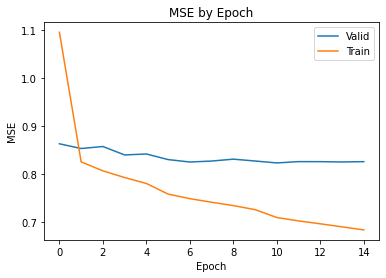

In [40]:
import matplotlib.pyplot as plt

plt.plot(trainer.results['valid_mse'], label='Valid')
plt.plot(trainer.results['train_mse'], label='Train')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE by Epoch')
plt.show()

In [41]:
{e:v for e,v in enumerate(torch.sqrt(torch.tensor(trainer.results['valid_mse'])))}

{0: tensor(0.9292),
 1: tensor(0.9239),
 2: tensor(0.9262),
 3: tensor(0.9166),
 4: tensor(0.9177),
 5: tensor(0.9113),
 6: tensor(0.9086),
 7: tensor(0.9097),
 8: tensor(0.9118),
 9: tensor(0.9097),
 10: tensor(0.9075),
 11: tensor(0.9090),
 12: tensor(0.9090),
 13: tensor(0.9086),
 14: tensor(0.9090)}

<hr>

# DEBUGGING

In [62]:
dl = DataLoader(train, 32)
z = next(iter(dl))
z

[{'user': tensor([  66, 1566, 1665,   60,   30, 2355, 1692,   64,  934, 1067, 1065, 2515,
           566, 1637,  862,  129,  219, 1960,   17,   28,  441,  327,   53,  431,
            27,  812, 2028,  803,  137, 2515, 1158,  682]),
  'movie': tensor([3132, 3132, 3132, 3132, 3132, 2821, 3132, 3132, 3132, 3132, 3132, 3132,
          3132, 3132, 3132, 3132, 3132, 3132, 3132, 2823, 3132, 3132, 3132, 3132,
          3132, 3132, 3132, 3132, 3132, 3132, 3132, 2823]),
  'hour': tensor([ 1,  3, 17, 20,  6, 21,  6,  7, 23, 23, 12, 21, 21, 21,  0,  0,  2, 14,
          15, 18,  4, 13, 16, 16, 17,  8, 21,  2,  3,  4,  6,  8]),
  'day_of_week': tensor([2, 2, 5, 2, 6, 2, 0, 5, 3, 3, 2, 5, 4, 5, 4, 5, 0, 3, 3, 0, 6, 3, 0, 1,
          5, 1, 2, 4, 1, 0, 2, 2]),
  'month': tensor([ 4,  4,  4,  4,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
           8,  8,  9,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 11]),
  'gender': tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,

In [86]:
user_embeds = nn.Embedding(
    num_embeddings=max(meta['occupations'])+1,
    embedding_dim=25
)

In [93]:
user_embeds(z[0]['occupation']).shape

torch.Size([32, 25])

In [120]:
z[0]['gender'].dtype

torch.int64

In [121]:
stack_features(z[0], 'genre').float()

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.,

In [122]:
meta['movie']

{'2858': 0.003427283697707179,
 '260': 0.002990375011622571,
 '1196': 0.002989375220578899,
 '1210': 0.0028823975789060087,
 '480': 0.0026714416686912435,
 '2028': 0.002652445638861478,
 '589': 0.0026484464746867904,
 '2571': 0.0025894588031101498,
 '1270': 0.002582460265804447,
 '593': 0.0025774613105860873,
 '1580': 0.0025374696688392124,
 '1198': 0.0025134746837910875,
 '608': 0.0025124748927474157,
 '2762': 0.002458486176389135,
 '110': 0.002442489519690385,
 '2396': 0.002368504982458666,
 '1197': 0.0023175156392314005,
 '527': 0.0023035185646199945,
 '1617': 0.0022875219079212445,
 '1265': 0.0022775239974845256,
 '1097': 0.002268525878091479,
 '2628': 0.002249529848261713,
 '2997': 0.0022405317288686664,
 '318': 0.0022265346542572604,
 '858': 0.002222535490082573,
 '356': 0.0021935415498160883,
 '2716': 0.002180544266248354,
 '296': 0.0021705463558116356,
 '1240': 0.0020975616096235885,
 '1': 0.0020765659977064793,
 '1214': 0.00202357707239187,
 '2916': 0.0019955829231690578,
 '45